In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta

In [2]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

## Cartera Individual

In [3]:
# Reading Data
data_w = pd.read_excel('../raw_data/weekly_data_clean_with_covid_ind.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0')
data_d = pd.read_excel('../raw_data/daily_data_clean_with_covid_ind.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0')


In [48]:
data_ind= pd.read_excel('../raw_data/weekly_data_clean_with_covid_ind.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0').set_index('date_issue')
data_col= pd.read_excel('../raw_data/weekly_data_clean_with_covid_col.xlsx', engine='openpyxl').drop(columns= 'Unnamed: 0').set_index('date_issue')

In [50]:
data_col

,amount,covid_claims
date_issue,,
2018-09-03,8730,0
2018-09-10,148950,0
2018-09-17,118735,0
2018-09-24,150795,0
2018-10-01,40850,0
...,...,...
2021-02-08,1107180,96
2021-02-15,1048086,106
2021-02-22,1047364,94


In [4]:
#Check Nulls
data_w.isnull().sum(), data_d.isnull().sum()

(date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64)

In [5]:
# Check types and lenght
data_w.dtypes, len(data_w), data_d.dtypes, len(data_d)

(date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 132,
 date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 919)

In [6]:
# Setting index as date
data_w = data_w.set_index('date_issue')
data_d = data_d.set_index('date_issue')


In [7]:
data_d

,amount,covid_claims
date_issue,,
2018-09-01,168,0
2018-09-02,332,0
2018-09-03,7453,0
2018-09-04,5025,0
2018-09-05,16023,0
...,...,...
2021-03-04,175724,27
2021-03-05,112495,22
2021-03-06,264350,21


<AxesSubplot:xlabel='date_issue'>

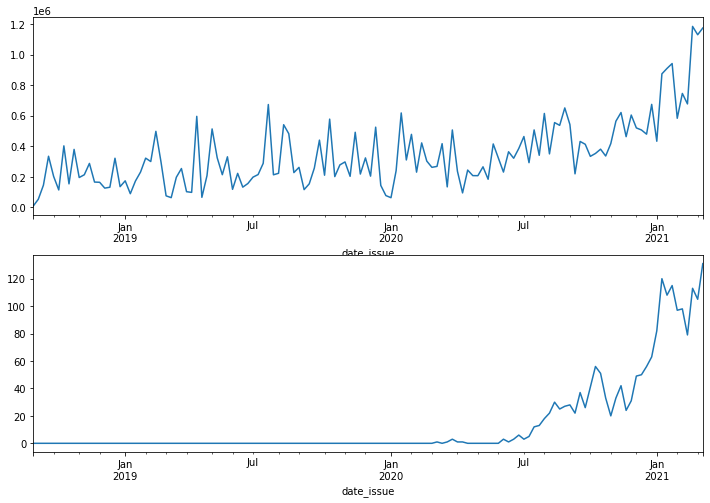

In [8]:
#Plotting weekly
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_w['amount'].plot(ax=ax1)
data_w['covid_claims'].plot(ax=ax2)


<AxesSubplot:xlabel='date_issue'>

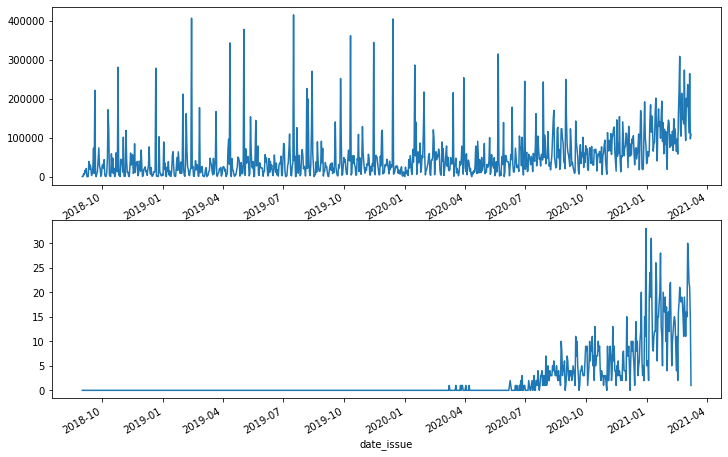

In [9]:
#Plotting daily
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_d['amount'].plot(ax=ax1)
data_d['covid_claims'].plot(ax=ax2)

### Trying with weekly data

In [10]:
# Checking for stationarity
pvalue_a = adfuller(data_w['amount'])[1]

pvalue_c = adfuller(data_w['covid_claims'])[1]

def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_a), pvalue_a, stationary(pvalue_c), pvalue_c

TS is not stationary
TS is not stationary


(None, 0.987088618524165, None, 1.0)

In [11]:
# Splitting Weekly data 

split = 0.7
split_index = round(len(data_w)*split)

train = data_w.iloc[:split_index]
test = data_w.iloc[split_index:]



In [12]:
# Separating variables
endog_train = train.drop(columns = 'covid_claims')
exog_train = train.drop(columns = 'amount')
endog_test = test.drop(columns = 'covid_claims')
exog_test = test.drop(columns = 'amount')

In [13]:
endog_test.head(1), exog_test.head(1), endog_test.tail(1), exog_test.tail(1)


(            amount
 date_issue        
 2020-06-08  230834,
             covid_claims
 date_issue              
 2020-06-08             3,
              amount
 date_issue         
 2021-03-08  1174264,
             covid_claims
 date_issue              
 2021-03-08           131)

In [14]:
autoarima_raw = pm.auto_arima(y = endog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1078.059, Time=0.75 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1106.095, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1062.227, Time=0.84 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1069.415, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1057.202, Time=1.63 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1055.202, Time=0.86 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1057.202, Time=3.56 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=3.78 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1057.013, Time=1.43 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1056.584, Time=2.60 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1056.775, Time=2.34 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1058.428, Time=1.33 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

In [15]:
autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -524.601
Date:                             Mon, 15 Mar 2021   AIC                           1055.202
Time:                                     15:05:25   BIC                           1060.192
Sample:                                          0   HQIC                          1056.992
                                              - 92                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9402      0.284     -3.310      0.001      -1.497      -0.383
ar.S.L52      -0.9352      0.226     -4.145      0.000      -1.377      -0.493
sigma2      4.959e+10   1.91e-12   2.59e+22      0.000    4.96e+10    4.96e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):                 2.66
Prob(Q):                              0.37   Prob(JB):                         0.26
Heteroskedasticity (H):               0.88   Skew:                             0.63
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.51e+38. Standard errors may be unstable.
"""

In [16]:
# Build model
best_sarima = SARIMAX(endog= endog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [17]:
prediction = best_sarima.get_prediction(start = '2020-06-08', end = '2021-03-08', dynamic = True, full_results = True)


In [18]:
prediction.row_labels

DatetimeIndex(['2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29',
               '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27',
               '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
               '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
               '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
               '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
               '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [19]:
predicted_amount = prediction.prediction_results.forecasts[0]

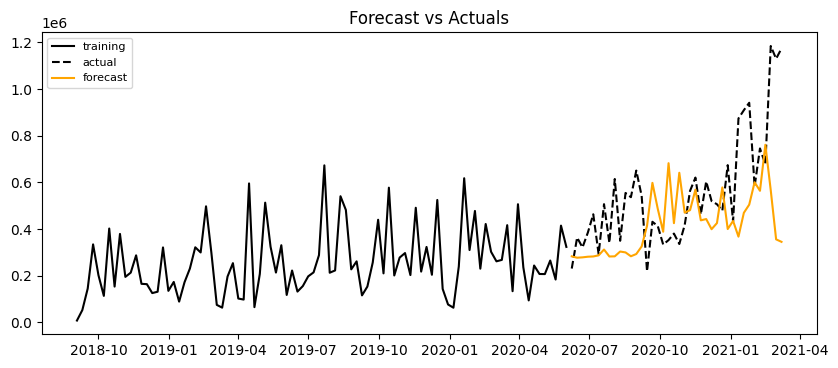

In [20]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [21]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

204818.27751986665

In [22]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.337141776654945

In [23]:
pred_ci = prediction.conf_int(alpha=0.05)

In [24]:
pred_ci.head(2)

,lower amount,upper amount
2020-06-08,-153463.590748,719845.900477
2020-06-15,-160099.688660,714775.720555


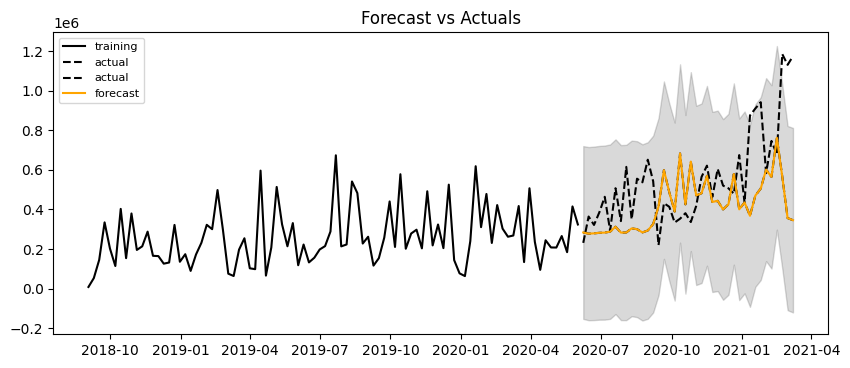

In [25]:
plot_forecast(predicted_amount, endog_train, endog_test, upper= pred_ci['upper amount'].values, lower= pred_ci['lower amount'].values)

### Best Model

### Split = 0.7

Best model: ARIMA(0,1,1)(1,1,0)[52] AIC = 1055.20

#### MAE= 204818.27751986665 
#### MAPE= 0.337141776654945

No exog variable

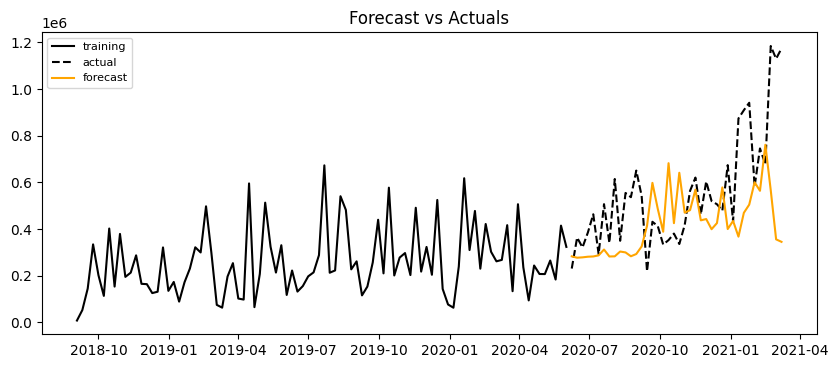

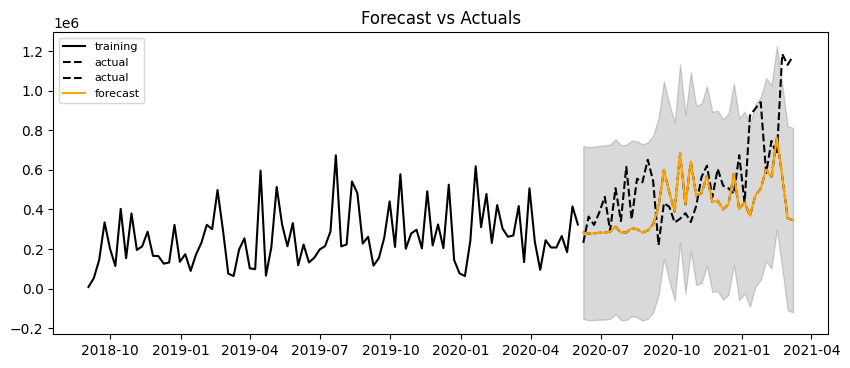



### Getting future prediction

In [26]:
# Plotting future forecast function

def plot_future_forecast(past_data, prediction, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    prediction = pd.Series(prediction[0], index=prediction.index)
    lower_series = pd.Series(upper, index=prediction.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=prediction.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(past_data, label='past_data', color='black')
    plt.plot(prediction, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast')
    plt.legend(loc='upper left', fontsize=8);

In [27]:
# Predicting future
future_prediction = best_sarima.get_prediction(start = '2021-03-09', end = '2021-04-09', dynamic = True, full_results = True)

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [28]:
future_predicted_amount = future_prediction.prediction_results.forecasts[0]

In [29]:
future_predicted_amount_df = pd.DataFrame(future_predicted_amount, index=future_prediction.row_labels)

In [30]:
future_pred_ci = future_prediction.conf_int(alpha=0.05)

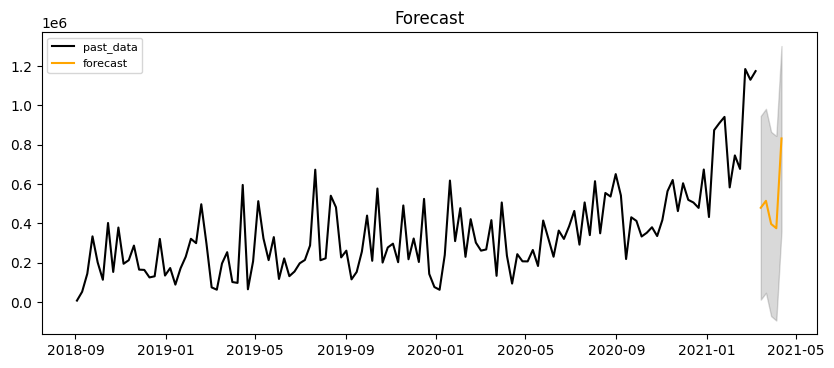

In [31]:
plot_future_forecast(data_w['amount'], future_predicted_amount_df, upper= future_pred_ci['upper amount'].values, lower= future_pred_ci['lower amount'].values)



### Get future prediction with a model trained with the whole dataset

In [32]:
# Build and train model
best_sarima_full_data = SARIMAX(endog= data_w['amount'], order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima_full_data = best_sarima_full_data.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [33]:
# Predict
future_prediction_full_data = best_sarima_full_data.get_prediction(start = data_w.index[-1] + timedelta(days=1), end = '2021-04-09', dynamic = True, full_results = True)

In [34]:
# Creating results and CI to plot
future_predicted_amount_full_data = future_prediction_full_data.prediction_results.forecasts[0]
future_predicted_amount_df_full_data = pd.DataFrame(future_predicted_amount_full_data, index=future_prediction_full_data.row_labels)
future_pred_ci_full_data = future_prediction_full_data.conf_int(alpha=0.05)

In [35]:
data_w.index[-1]

Timestamp('2021-03-08 00:00:00')

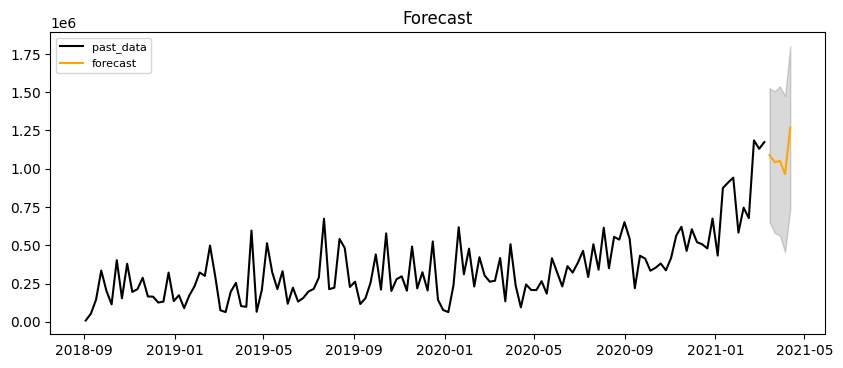

In [36]:
# Plotting
plot_future_forecast(data_w['amount'], future_predicted_amount_df_full_data, upper= future_pred_ci_full_data['upper amount'].values, lower= future_pred_ci_full_data['lower amount'].values)


In [40]:
def predict_col(data_col, end_date):
    # Build and train model
    best_sarima_full_data = SARIMAX(endog= data_col['amount'], order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
    best_sarima_full_data = best_sarima_full_data.fit()
    # Predict
    future_prediction_full_data = best_sarima_full_data.get_prediction(start = data_col.index[-1] + timedelta(days=1), end = end_date, dynamic = True, full_results = True)
    # Create results and confidence intervals
    future_predicted_amount_full_data = future_prediction_full_data.prediction_results.forecasts[0]
    future_predicted_amount_df_full_data = pd.DataFrame(future_predicted_amount_full_data, index=future_prediction_full_data.row_labels)
    future_pred_ci_full_data = future_prediction_full_data.conf_int(alpha=0.05)
    # Plotting
    return plot_future_forecast(data_col['amount'], future_predicted_amount_df_full_data, upper= future_pred_ci_full_data['upper amount'].values, lower= future_pred_ci_full_data['lower amount'].values)


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


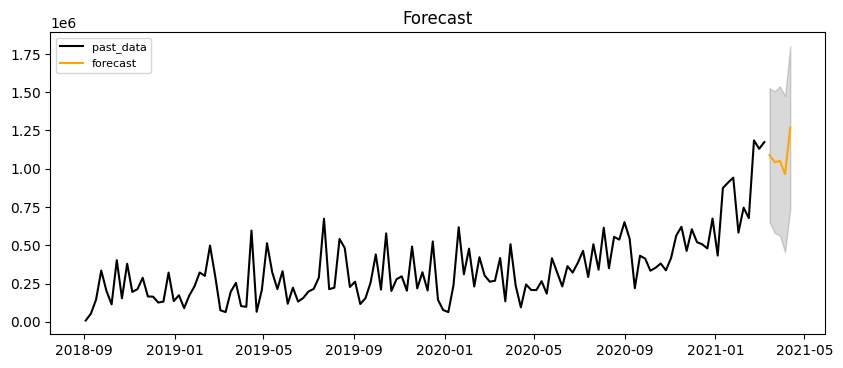

In [44]:
predict_col(data_w, end_date='2021-04-09')

#### Creating a plot with both predictions

,amount_x,covid_claims_x,amount_y,covid_claims_y,total_amount
date_issue,,,,,
2018-09-03,8730,0,7953,0,16683
2018-09-10,148950,0,52824,0,201774
2018-09-17,118735,0,144926,0,263661
2018-09-24,150795,0,334429,0,485224
2018-10-01,40850,0,202143,0,242993
...,...,...,...,...,...
2021-02-08,1107180,96,745803,98,1852983
2021-02-15,1048086,106,677139,79,1725225
2021-02-22,1047364,94,1184838,113,2232202


In [55]:
def predictions_and_ci(data_col, end_date):
    # Build and train model
    best_sarima_full_data = SARIMAX(endog= data_col['amount'], order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
    best_sarima_full_data = best_sarima_full_data.fit()
    # Predict
    future_prediction_full_data = best_sarima_full_data.get_prediction(start = data_col.index[-1] + timedelta(days=1), end = end_date, dynamic = True, full_results = True)
    # Create results and confidence intervals
    future_predicted_amount_full_data = future_prediction_full_data.prediction_results.forecasts[0]
    future_predicted_amount_df_full_data = pd.DataFrame(future_predicted_amount_full_data, index=future_prediction_full_data.row_labels)
    future_pred_ci_full_data = future_prediction_full_data.conf_int(alpha=0.05)
    # Plotting
    return future_predicted_amount_df_full_data, future_pred_ci_full_data


In [56]:
col_pred, col_ci = predictions_and_ci(data_col, '2021-04-09')

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [58]:
col_pred, col_ci

(                       0
 2021-03-15  1.065647e+06
 2021-03-22  1.153512e+06
 2021-03-29  1.043110e+06
 2021-04-05  1.088976e+06
 2021-04-12  1.195247e+06,
              lower amount  upper amount
 2021-03-15  819981.798758  1.311313e+06
 2021-03-22  873039.938101  1.433985e+06
 2021-03-29  731697.157754  1.354523e+06
 2021-04-05  749430.801174  1.428522e+06
 2021-04-12  829727.110728  1.560766e+06)

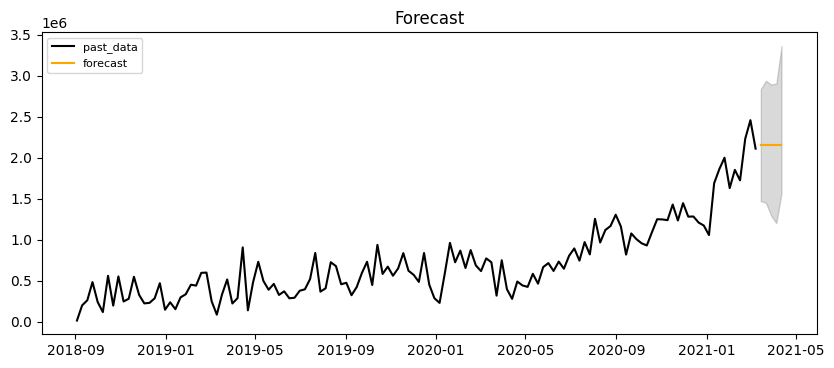

In [72]:
total_df = data_col.merge(data_ind, right_index=True, left_index=True)
total_df['total_amount']= total_df['amount_x'] + total_df['amount_y']
col_pred= pd.DataFrame(col_pred)
col_ci= pd.DataFrame(col_ci)
merged_pred = future_predicted_amount_df_full_data.merge(col_pred, right_index=True, left_index=True)
merged_pred['total_pred']= merged_pred['0_x'] + merged_pred['0_y']
merged_ci = future_pred_ci_full_data.merge(col_ci, right_index=True, left_index=True)
merged_ci['total_lower_amount'] = merged_ci['lower amount_x'] + merged_ci['lower amount_y']
merged_ci['total_upper_amount'] = merged_ci['upper amount_x'] + merged_ci['upper amount_y']
plot_future_forecast(total_df['total_amount'], merged_pred['total_pred'], upper= merged_ci['total_upper_amount'].values, lower= merged_ci['total_lower_amount'].values)


In [ ]:
def predict_total_plot(end_date):

    # Plotting
    return plot_future_forecast(data_col['amount'], future_predicted_amount_df_full_data, upper= future_pred_ci_full_data['upper amount'].values, lower= future_pred_ci_full_data['lower amount'].values)